In [1]:
import sys
sys.path.append("..")

import os
import json
from collections import Counter
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from egh_vlm.utils import load_phd_dataset

## Analysis

In [2]:
dataset_path = "../data/phd/phd_sampled_qwen3_vl_2b_full.json"
img_folder_path = "../data/phd/images"

dataset = load_phd_dataset(dataset_path, img_folder_path)
df = pd.DataFrame(dataset)
df.head()

Successfully load the PhD dataset with: 7500 samples.


,id,question,answer,image_path,label,task,context,hitem,subject,gt,question_gt
0,0,Is any of the shirts in the image gray?,"no, the shirts in the image are white",../data/phd/images\val2014\COCO_val2014_000000...,0,attribute,"{'icc': 'In a lively living room setting, two ...",gray,shirts,white,0
1,1,Is the monitor screen rectangular in shape?,"yes, the monitor screen is rectangular in shape.",../data/phd/images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The monitor screen is circular in sha...,circular,monitor screen,rectangle,1
2,2,Is the floor made of acrylic in the image?,"no, the floor is not made of acrylic. the floo...",../data/phd/images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The floor in the image is made of acr...,acrylic,floor,vase,0
3,3,Is the woman wearing black in the image?,"yes, the woman is wearing black. She is wearin...",../data/phd/images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The woman in the image is wearing whi...,white,woman,black,1
4,4,Is the back wall made of brick in the image?,"yes, the back wall has brick on the right side...",../data/phd/images\val2014\COCO_val2014_000000...,0,attribute,"{'icc': 'In a recent event, two men took the s...",Concrete,back wall,brick,1


In [3]:
image_paths = df["image_path"].to_list()
print(f"Verify image paths")

for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Not found: {image_path}")

Verify image paths


In [4]:
label_counts = df["label"].value_counts()
label_counts

label
0    5615
1    1885
Name: count, dtype: int64

answes lengths mean: 27.65
answer lengths median: 27.0
answer lengths q1: 11.0
answer lengths q3: 40.0


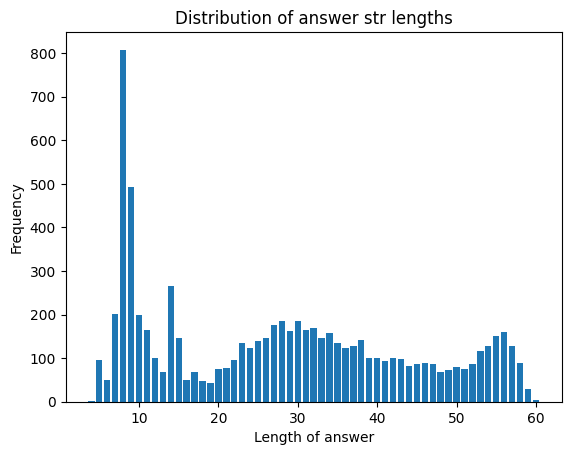

In [5]:
answers = df["answer"].to_list()
answer_legnths = [len(data.split(" ")) for data in answers]
answer_legnths_counts = Counter(answer_legnths)

print(f"answes lengths mean: {round(np.mean(answer_legnths), 2)}")
print(f"answer lengths median: {round(np.median(answer_legnths), 2)}")
print(f"answer lengths q1: {round(np.quantile(answer_legnths, 0.25), 2)}")
print(f"answer lengths q3: {round(np.quantile(answer_legnths, 0.75), 2)}")

plt.figure()
plt.bar(answer_legnths_counts.keys(), answer_legnths_counts.values())
plt.xlabel("Length of answer")
plt.ylabel("Frequency")
plt.title("Distribution of answer str lengths")
plt.show()

## Generate balanced label dataset 

In [6]:
file_path = "../data/phd/phd_sampled_qwen3_vl_2b_full.json"

with open(file_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

In [7]:
def get_balanced_raw_dataset(dataset):
    label_counts = Counter(item["hallucinated_label"] for item in dataset)
    print("Label distribution before balancing:\n", label_counts)

    min_count = min(label_counts.values())
    print(f"Max balanced count per label: {min_count}")

    balanced_dataset = []

    for label in label_counts:
        label_samples = [item for item in dataset if item["hallucinated_label"] == label]
        balanced_dataset.extend(random.sample(label_samples, min_count))
    random.shuffle(balanced_dataset)
    print(f"Balanced dataset size: {len(balanced_dataset)}")
    print("Label distribution after balancing:\n", Counter(item["hallucinated_label"] for item in balanced_dataset))
    print("Task distribution after balancing:\n", Counter(item["task"] for item in balanced_dataset))
    return balanced_dataset

balanced_dataset = get_balanced_raw_dataset(dataset)

Label distribution before balancing:
 Counter({0: 5615, 1: 1885})
Max balanced count per label: 1885
Balanced dataset size: 3770
Label distribution after balancing:
 Counter({0: 1885, 1: 1885})
Task distribution after balancing:
 Counter({'sentiment': 884, 'counting': 875, 'attribute': 708, 'positional': 695, 'object': 608})


In [8]:
df_balanced = pd.DataFrame(balanced_dataset)
df_balanced.head()

,id,task,yes_question,no_question,context,image_id,hitem,subject,gt,question,label,qwen3_vl_2b_response,hallucinated_label
0,6151,sentiment,Is the cat showing an angry expression in the ...,Is the cat content in the image?,{'icc': 'The cat in the image appears to be co...,000000046090,content,cat,angry,Is the cat showing an angry expression in the ...,1,"yes, the cat is showing an angry expression in...",0
1,7396,sentiment,Is the man depicted as brave in the image?,Is the man expressing a feeling of longing in ...,"{'icc': 'In the poignant image, the man is exp...",000000072424,longing,man,brave,Is the man depicted as brave in the image?,1,"no, the man is not depicted as brave in the im...",1
2,6376,sentiment,Is the moon depicted as happy in the image?,Is the moon appearing relieved in the image?,{'icc': 'The image shows the moon appearing re...,000000453643,relieved,moon,happy,Is the moon appearing relieved in the image?,0,"yes, explanation based on what you see in the ...",1
3,6249,sentiment,Is the child expressing happiness in the image?,Is the child displaying mischievous behavior i...,{'icc': 'The child in the image is exhibiting ...,000000127880,mischievous,child,happy,Is the child displaying mischievous behavior i...,0,"yes, explanation based on what you see in the ...",1
4,1963,counting,Are there four planes in the image?,Are there 3 planes in the image?,"{'icc': 'In the recent photo, there are 3 plan...",000000250226,3,planes,four,Are there 3 planes in the image?,0,"yes, there are 3 planes in the image.",1


In [9]:
save_path = "../data/phd/phd_sampled_qwen3_vl_2b_full_balanced.json"
output = df_balanced.to_dict("records")

with open(save_path, "w") as f:
    json.dump(output, f, indent=4)